# Imports

In [1]:
import os
import torch
from tqdm import tqdm
from random import randint
import numpy as np
import matplotlib.pyplot as plt
import gc

if not os.path.exists('data'):
    new_directory_path = "..\\..\\"
    os.chdir(new_directory_path)


from src.eval.eval_metrics import precision,recall,create_cls_targets, accuracy, eval_reg
from src.eval.eval_utils import plt_training_metrics, gather_best_metrics
from src.eval.vis_scanpath import draw_scanpath_mpl
from src.model.model_io import load_models_with_data
from src.training.training_utils import move_data_to_device, compute_loss


## Methods

In [2]:
def get_coords(idx, x,y, fixation_len, reg_out):
    if torch.all(x < 2):
        x = x.clone()
        x[:,:,0] = x[:,:,0] * 512
        x[:,:,1] = x[:,:,1] * 320
    x_coords = x[idx,:,:2].cpu().numpy().T
    y_coords = y[idx,:fixation_len[idx],:2].cpu().numpy().T
    reg_coords = reg_out[idx,:fixation_len[idx],:2].cpu().numpy().T
    x_coords = x_coords[:,::-1]
    y_coords = y_coords[:,::-1]
    reg_coords = reg_coords[:,::-1]
    return x_coords, y_coords, reg_coords

def batch_to_list(x, fixation_len = None):
    # convert from padded batch [B,T,F] to list of numpy arrays with shape [F,N]
    x_list = []
    for i in range(x.size(0)):
        l = 0
        if fixation_len is None:
            l = x.size(1)
        else:
            l = fixation_len[i]
        x_i = x[i,:l, :].cpu().numpy().T
        x_list.append(x_i)
    return x_list

def compute_classification_scores(cls_out,fixation_len):
    acum = np.zeros(7)
    count = np.zeros(7)
    all_count = 0
    for i in range(cls_out.shape[0]):
        cls_out_sample = cls_out[i]
        cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
        s = 3 - min(3, fixation_len[i])
        e = 3 + min(7,cls_out_sample.shape[1] - fixation_len[i])
        acum[s:e] += cls_out_sample[0,max(0,fixation_len[i]-3): fixation_len[i]+4 ]
        count[s:e] +=1
        all_count += 1
    avg = acum / count
    image_data = avg.reshape(7, 1).T
    count = (count/all_count).reshape(7, 1).T
    image_data = np.concat((image_data, count), axis=0)
    return image_data

def plot_scores(image_data, title, x_ticks, y_ticks):
    plt.figure(figsize= (image_data.shape[1] + 1, image_data.shape[0])) # Set the figure size to be tall and thin
    plt.imshow(image_data, cmap='gray', interpolation='nearest', aspect='auto')
    text_color = 'green' 
    for i in range(image_data.shape[0]):
        for j in range(image_data.shape[1]):
            score = image_data[i, j]
            
            plt.text(j, i, f'{score:.2f}', 
                        ha="center", va="center", color=text_color, fontsize=10)
    
    plt.title(title)
    xtick_coords, xtick_labels = x_ticks
    ytick_coords, ytick_labels = y_ticks
    
    plt.xticks(xtick_coords, xtick_labels) # Optional: keep y-axis labels for reference
    plt.yticks(ytick_coords, ytick_labels)
    
    plt.show()

def plot_classification_scores(image_data, title="Classification Scores"):
    plot_scores(image_data, title, 
                (range(7), [f'Token {i-3}' if i != 3 else 'END' for i in range(7)]),
                (range(2), ['score', 'sample per']))
    
def plot_reg_scores(image_data, title="Regression Scores"):
    plot_scores(image_data, title, 
                (range(image_data.shape[1]), [f'Token {i}' for i in range(image_data.shape[1])]),
                (range(3),['coords', 'dur', 'sample per']))
    
def invert_transforms(inputs, outputs, dataloader):
    pred_reg = outputs['reg']
    gt_reg = inputs['tgt']
    transforms = dataloader.path_dataset.transforms
    # reverse the transforms
    for transform in reversed(transforms):
        if transform.modify_y:
            pred_reg = transform.inverse(pred_reg)
            gt_reg = transform.inverse(gt_reg)
    outputs['reg'] = pred_reg
    inputs['tgt'] = gt_reg
    return inputs, outputs



In [3]:
import torch

B, H, W, F, L = 2, 16, 16, 64, 10
visual_tokens = torch.randn(B, H * W, F)
coords = torch.rand(B, L, 2)

coords = torch.floor(coords * 16).long()
visual_tokens = visual_tokens.view(B, H, W, F)

grid_h = coords[:, :, 0] 
grid_w = coords[:, :, 1]

batch_idx = torch.arange(B).unsqueeze(1).to(visual_tokens.device)

selected = visual_tokens[batch_idx, grid_h, grid_w]

print("Selected shape:", selected.shape) # Output: torch.Size([2, 10, 64])

Selected shape: torch.Size([2, 10, 64])


In [4]:
selected.shape

torch.Size([2, 10, 64])

# Eval

## Review Metrics

In [5]:


metric_path = ["metrics (1).json", "metrics (2).json"]

C:\Users\ulloa\AppData\Local\Temp\ipykernel_6240\1592672725.py:29: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


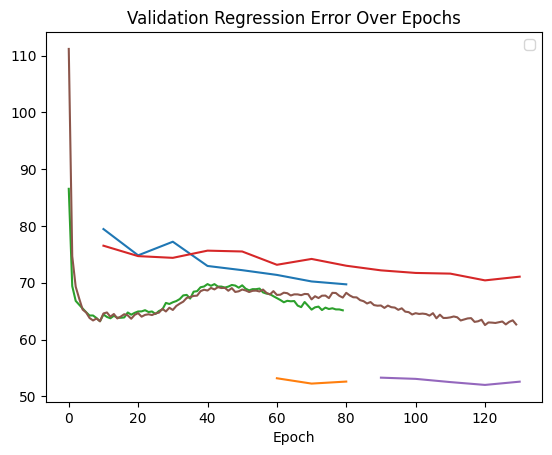

In [6]:
import json
import matplotlib.pyplot as plt
with open(metric_path[0], 'r') as f:
    data = json.load(f)


epochs_val = [(i + 1)*10 for i in range(len(data['reg_error_val']))]
epoch_combined_val = [60 + i*10 for i in range(len(data['denoise_error_val']))]
epochs_train = [i for i in range(len(data['coord_error_train']))]
plt.plot(epochs_val, data['reg_error_val'])
plt.plot(epoch_combined_val, data['denoise_error_val'])
plt.plot(epochs_train, data['coord_error_train'])
plt.xlabel("Epoch")

with open(metric_path[1], 'r') as f:
    data = json.load(f)

epochs_val = [(i + 1)*10 for i in range(len(data['reg_error_val']))]
epoch_combined_val = [90 + i*10 for i in range(len(data['denoise_error_val']))]
epochs_train = [i for i in range(len(data['coord_error_train']))]
plt.plot(epochs_val, data['reg_error_val'])
plt.plot(epoch_combined_val, data['denoise_error_val'])
plt.plot(epochs_train, data['coord_error_train'])
#plt.ylabel("Validation Regression Error")
#plt.axvline(x=10, color='red', linestyle='--', label='sampling warmup')
#plt.axvline(x=40, color='green', linestyle='--', label='samplint 0.7')
#plt.axvline(x=50, color='blue', linestyle='--', label='Combined')
#
plt.legend()

plt.title("Validation Regression Error Over Epochs")
plt.show()

## Checkout Output

### Eval Just One Batch

In [19]:
input_outputs = torch.load('inputs_outputs.pth', map_location='cpu')
print('>> All models:')
for model in input_outputs:
    print(model['model_name'])
    
to_test = ['path model', 'clean_eye + gaussian noise', 'best phase']
input_outputs = [model for model in input_outputs if model['model_name'] in to_test]
print('>> Models to test:')
for model in input_outputs:
    print(model['model_name'])

>> All models:
path model
clean_eye + gaussian noise
gaussian noise
phase 1
phase 2
best phase
>> Models to test:
path model
clean_eye + gaussian noise
best phase


In [20]:
for model in input_outputs:
    print(model['model_name'])
    acum_cls_loss = 0
    acum_reg_loss = 0
    acum_coord_error = 0
    acum_duration_error = 0
    count = 0
    for i in range(len(model['inputs'])):
        input, output = model['inputs'][i], model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        reg_out, cls_out = output['reg'], output['cls']
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        reg_error, dur_error = eval_reg(reg_out, y, y_mask)
        acum_cls_loss += cls_loss.item()
        acum_reg_loss += reg_loss.item()
        acum_coord_error += reg_error
        acum_duration_error += dur_error
        count += 1
    print(f'Cls Loss: {acum_cls_loss/count:.4f}, Reg Loss: {acum_reg_loss/count:.4f}')
    print(f'Regression error (pixels): {acum_coord_error/count:.4f}, Duration error ({acum_duration_error/count:.4f})')
    print('--------------------------------')

path model
Cls Loss: 0.6287, Reg Loss: 7922.5067
Regression error (pixels): 79.9113, Duration error (89.7330)
--------------------------------
clean_eye + gaussian noise
Cls Loss: 0.3874, Reg Loss: 7823.1674
Regression error (pixels): 55.6294, Duration error (90.8664)
--------------------------------
best phase
Cls Loss: 0.4358, Reg Loss: 7850.2749
Regression error (pixels): 69.2315, Duration error (89.8405)
--------------------------------


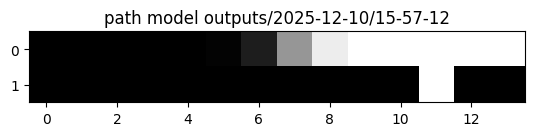

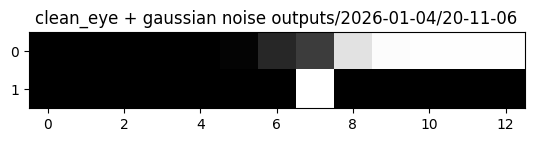

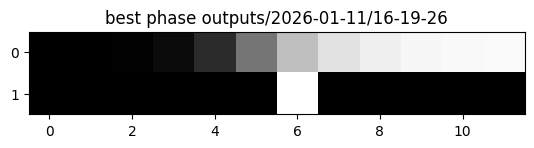

In [42]:
for i, model in enumerate(input_outputs):
    idx = randint(0,len(model['inputs']) - 1)
    reg_out, cls_out = model['outputs'][i]['reg'], model['outputs'][i]['cls']
    y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
    cls_out_sample = cls_out[idx]
    cls_out_sample = torch.sigmoid(cls_out_sample).cpu().numpy().T
    cls_targets = create_cls_targets(cls_out, fixation_len)
    cls_targets_sample = cls_targets[idx].cpu().numpy().T
    # vstack
    pair = np.vstack((cls_out_sample, cls_targets_sample)).T
    plt.imshow(pair.T, cmap='gray')
    plt.title(f'{model["model_name"]} {model["checkpoint_path"]}')
    plt.show()

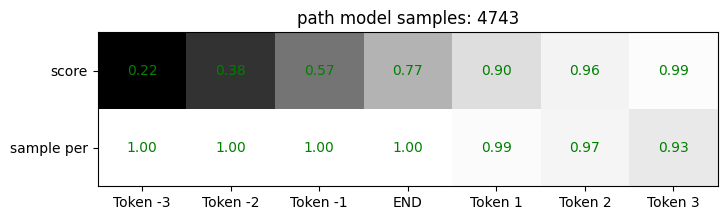

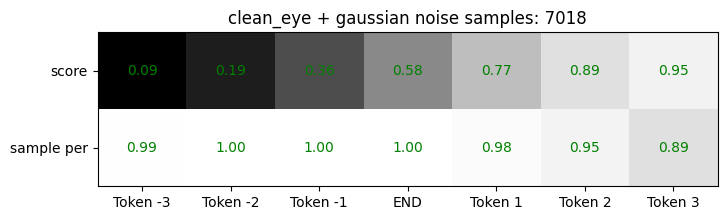

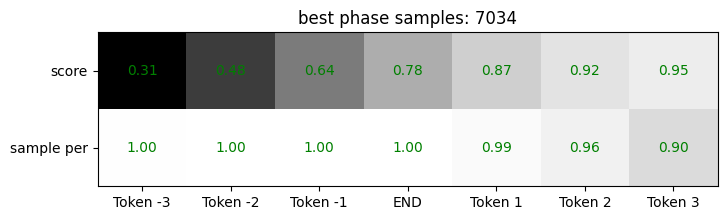

In [22]:

# put the value in each pixel
for  model in input_outputs:
    image_data_list = []
    count = 0
    for i in range(len(model['outputs'])):
        cls_out = model['outputs'][i]['cls']
        fixation_len = model['inputs'][i]['fixation_len']
        image_data = compute_classification_scores(cls_out, fixation_len)
        image_data_list.append(image_data)
        count += cls_out.shape[0]
    # Compute the mean image data across all samples, handling any potential NaNs for robustness
    image_data = np.nanmean(np.stack(image_data_list, axis=0), axis=0)
    plot_classification_scores(image_data, title=f"{model['model_name']} samples: {count}")

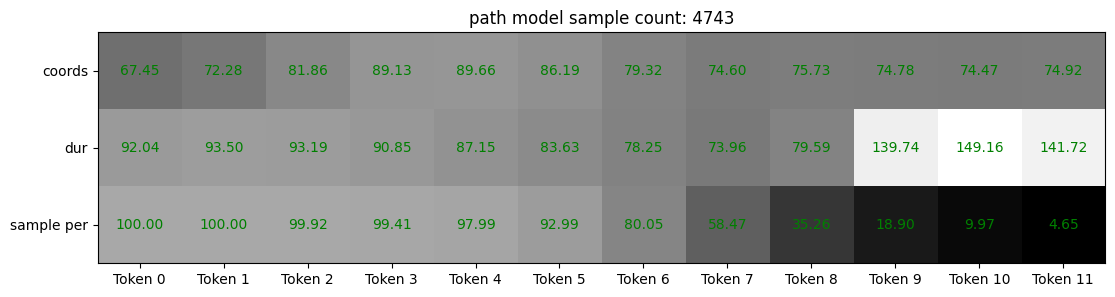

Skipped 1 samples


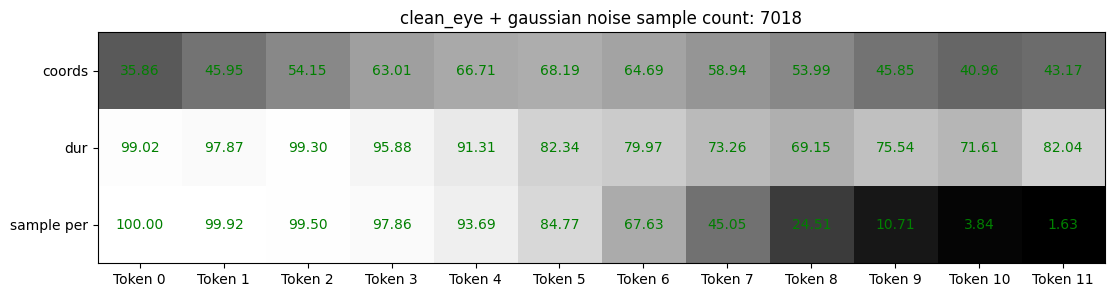

Skipped 14 samples


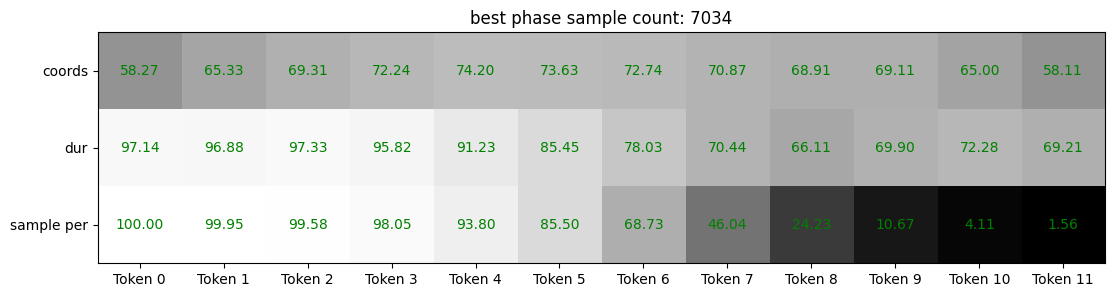

Skipped 7 samples


In [23]:
def error_distribution(reg, y, y_mask, remove_outliers = False):
    reg = reg.clone()
    y_mask = y_mask.unsqueeze(-1)[:,1:,:]
    count = y_mask.sum(dim = 0).squeeze().cpu().numpy()
    if remove_outliers:
        outliers = (reg[:,:-1,2:] > 1200) & y_mask
        reg[:,:-1,2:][outliers] = 1200
    diff = torch.where(y_mask, reg[:,:-1,:] - y, torch.tensor(0.0, device=y.device))
    diff_xy = diff[:,:,:2]
    reg_error = torch.sqrt(torch.sum(diff_xy**2, dim=-1))
    dur_error = torch.abs(diff[:,:,2])
    reg_error = reg_error.sum(dim = 0).cpu().numpy()
    dur_error = dur_error.sum(dim = 0).cpu().numpy()
    reg_error = (reg_error / count)[np.newaxis,:]
    dur_error = (dur_error / count)[np.newaxis,:]
    if remove_outliers:
        outliers_count = outliers.sum().item()
        return reg_error, dur_error, outliers_count
    else:
        return reg_error, dur_error

for model in input_outputs:
    image_data_list = []
    skipped_count = 0
    sample_count = 0
    for i in range(len(model['outputs'])):
        reg_out = model['outputs'][i]['reg']
        y, y_mask, fixation_len = model['inputs'][i]['tgt'], model['inputs'][i]['tgt_mask'], model['inputs'][i]['fixation_len']
        counts = y_mask[:,1:].sum(dim = 0)/y_mask.shape[0] * 100
        counts = counts.cpu().numpy()[np.newaxis, :]
        coord_error, dur_error, outliers_count = error_distribution(reg_out, y, y_mask, remove_outliers= True)
        image_data = np.concat((coord_error, dur_error, counts), axis=0)
        if image_data.shape[1] >= 12:
            image_data_list.append(image_data[:,:12])
        else:
            skipped_count += 1
        sample_count += reg_out.shape[0]
    image_data = np.nanmean(np.stack(image_data_list, axis=0), axis=0)
    plot_reg_scores(image_data, title=f"{model['model_name']} sample count: {sample_count}")
    print(f"Skipped {skipped_count} samples")
    
    

c:\Users\ulloa\OneDrive\Desktop\Practicas\projectes\Dataset\src\eval\vis_scanpath.py:18: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(x[-1], y[-1], s=marker_size, c=end_color, zorder=5)


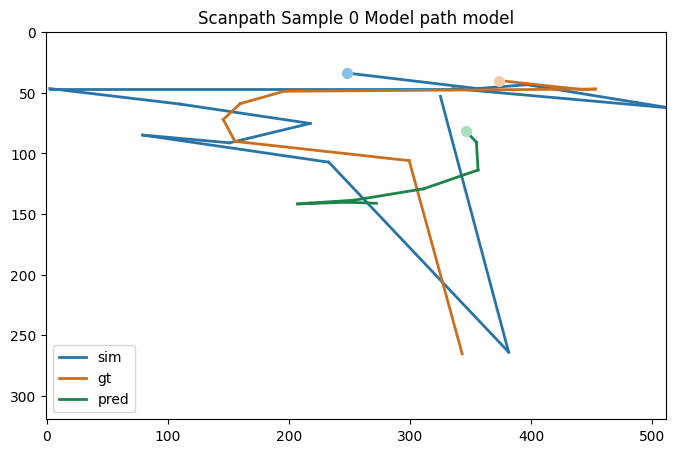

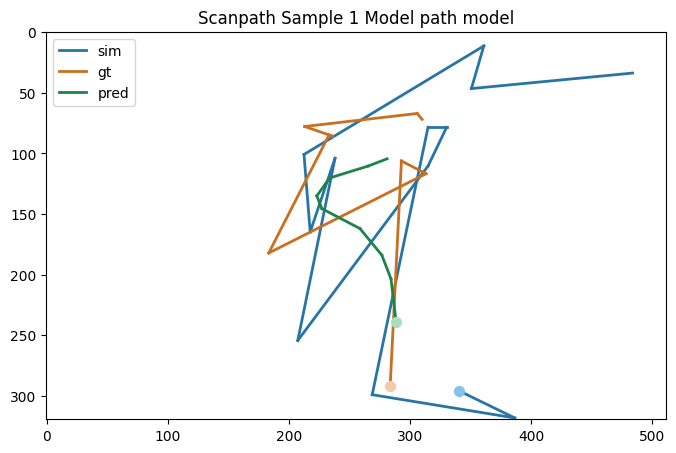

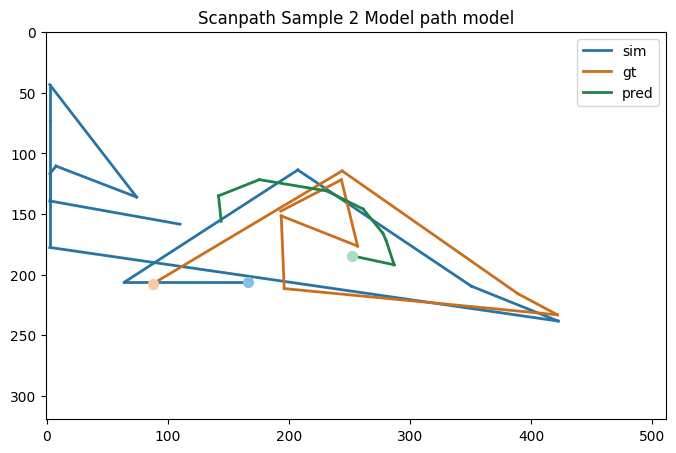

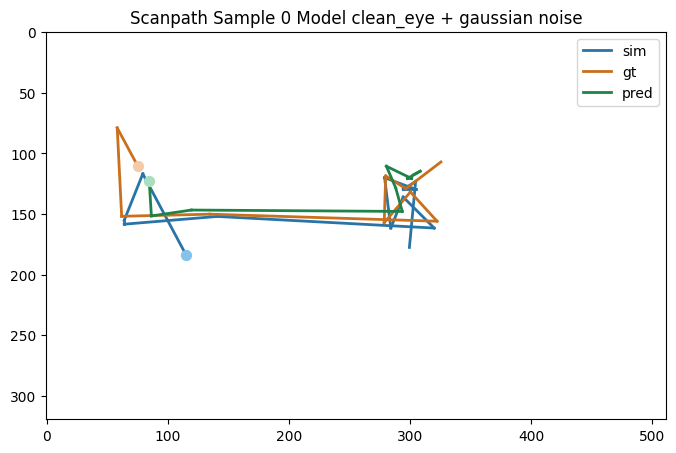

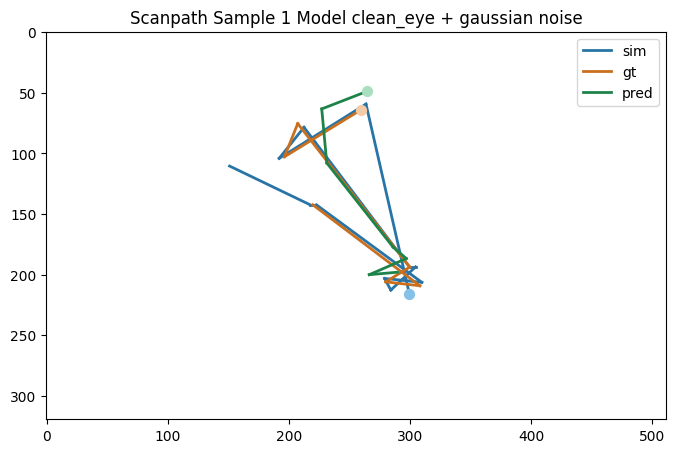

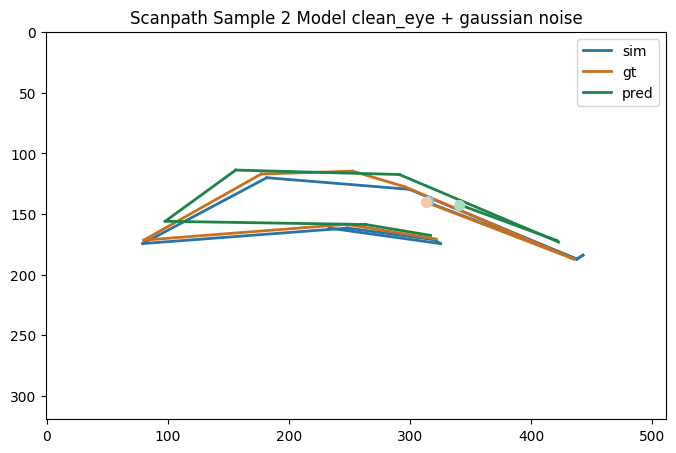

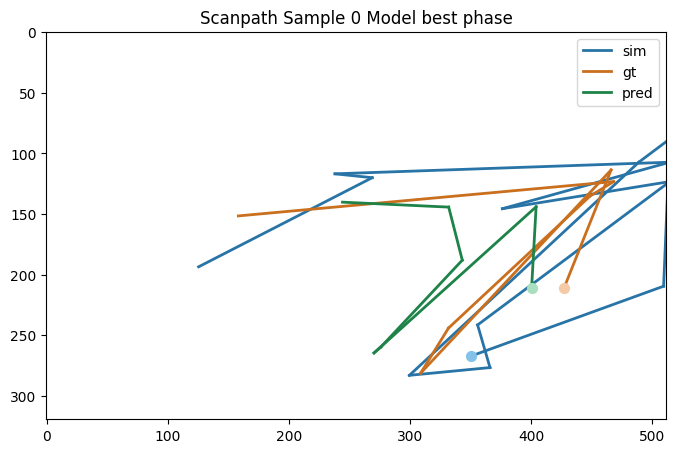

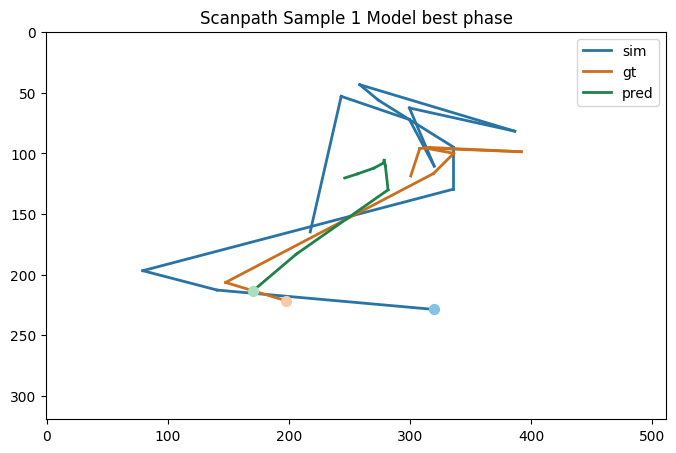

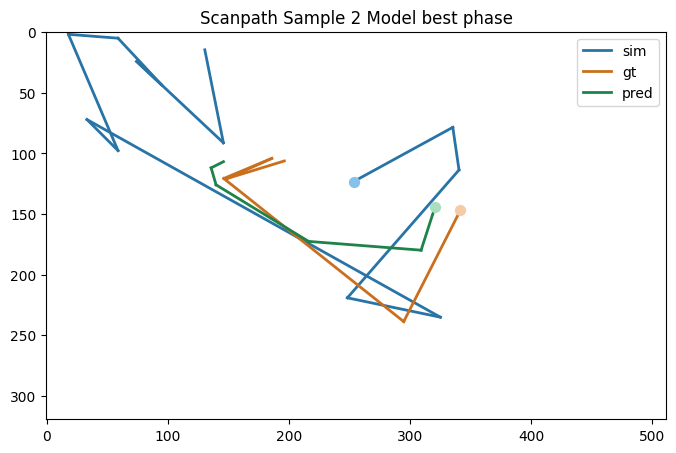

In [24]:

for model in input_outputs:
    for i in range(3):
        idx = randint(0,len(model['inputs']) - 1)
        reg_out, cls_out = model['outputs'][idx]['reg'], model['outputs'][idx]['cls']
        x, y, fixation_len = model['inputs'][idx]['src'], model['inputs'][idx]['tgt'], model['inputs'][idx]['fixation_len']
        x_coords, y_coords, reg_coords = get_coords(idx, x, y, fixation_len,reg_out)
        img = np.ones((320,512,3),dtype=np.uint8)*255

        label = ['sim', 'gt', 'pred']

        traj = [x_coords,
                y_coords, 
                reg_coords]
        traj_colors = [(40/255, 116/255, 166/255), # blue
                    (202/255, 111/255, 30/255), # orange
                    (29/255, 131/255, 72/255)] # green

        end_point_colors = [(133/255, 193/255, 233/255),
                            (245/255, 203/255, 167/255),
                            (169/255, 223/255, 191/255)]
        fig, ax = plt.subplots(figsize=(8,8))
        for traj, color, end_color, lbl in zip(traj, traj_colors, end_point_colors, label):
            ax = draw_scanpath_mpl(ax, traj[0],traj[1], color=color, end_color=end_color, label=lbl)

        plt.title(f'Scanpath Sample {i} Model {model["model_name"]}')
        plt.imshow(img)
        plt.legend()
        # plt.savefig(f'Output/scanpath_{i}_model_{model["model_name"]}.png')
        plt.show()


### Load Stats


In [25]:
acc_list = []
reg_loss_list = []
cls_loss_list = []
pre_pos_list = []
rec_pos_list = []
pre_neg_list = []
rec_neg_list = []
outliers_list = []
coord_error_list = []
dur_error_list = []
all_model_x_list = []
all_model_y_list = []
all_model_reg_list = []
all_coordinate_error = []
all_duration_error = []
for model in input_outputs:
    acc_acum = 0
    cls_loss_acum = 0
    reg_loss_acum = 0
    pre_pos_acum = 0
    rec_pos_acum = 0
    pre_neg_acum = 0
    rec_neg_acum = 0
    coord_error_acum = 0
    duration_error_acum = 0
    outliers_accum = 0
    all_batch_reg_error = []
    all_batch_duration_error = []
    reg_results = []
    y_results = []
    x_results = []
    count = 0
    for i in range(len(model['inputs'])):
        input = model['inputs'][i]
        output = model['outputs'][i]
        cls_loss, reg_loss = compute_loss(input, output)
        
        y, y_mask, fixation_len = input['tgt'], input['tgt_mask'], input['fixation_len']
        x = input['src']
        reg_out, cls_out = output['reg'], output['cls']
        cls_loss_acum += cls_loss.item()
        reg_loss_acum += reg_loss.item()
        cls_targets = create_cls_targets(cls_out, fixation_len)
        acc_acum += accuracy(cls_out, y_mask, cls_targets)
        pre_pos_acum += precision(cls_out, y_mask, cls_targets)
        rec_pos_acum += recall(cls_out, y_mask, cls_targets)
        pre_neg_acum += precision(cls_out, y_mask, cls_targets, cls = 0)
        rec_neg_acum += recall(cls_out, y_mask, cls_targets, cls = 0)
        coord_error, dur_error = eval_reg(reg_out, y, y_mask)
        coord_error_acum += coord_error
        all_batch_reg_error.append(coord_error)
        duration_error_acum += dur_error
        all_batch_duration_error.append(dur_error)
        outliers_accum += outliers_count
        reg_results += batch_to_list(reg_out, fixation_len)
        y_results += batch_to_list(y, fixation_len)
        x_results += batch_to_list(x)
        count += 1
    all_coordinate_error.append(all_batch_reg_error)
    all_duration_error.append(all_batch_duration_error)
    outliers_list.append(outliers_accum)
    acc_list.append(acc_acum/count)
    reg_loss_list.append(reg_loss_acum/count)
    cls_loss_list.append(cls_loss_acum/count)
    pre_pos_list.append(pre_pos_acum/count)
    rec_pos_list.append(rec_pos_acum/count)
    pre_neg_list.append(pre_neg_acum/count)
    rec_neg_list.append(rec_neg_acum/count)
    coord_error_list.append(coord_error_acum/count)
    dur_error_list.append(duration_error_acum/count)
    all_model_x_list.append(x_results)
    all_model_y_list.append(y_results)
    all_model_reg_list.append(reg_results)

In [26]:

# plot evaluation metrics using pandas 
import pandas as pd
# Transpose the dataframe so models are columns and metrics are rows
metrics_df = pd.DataFrame({
    'Reg_Loss': reg_loss_list,
    'Cls_Loss': cls_loss_list,
    'Accuracy': acc_list,
    'Precision_Pos': pre_pos_list,
    'Recall_Pos': rec_pos_list,
    'Precision_Neg': pre_neg_list,
    'Recall_Neg': rec_neg_list,
    'Coord_Error': coord_error_list,
    'Dur_Error': dur_error_list,
    'outliers Count': outliers_list
}, index=[f'{input_outputs[i]['model_name']}' for i in range(len(input_outputs))])
metrics_df = metrics_df.transpose()
metrics_df

,path model,clean_eye + gaussian noise,best phase
Reg_Loss,7922.506669,7823.167365,7850.274885
Cls_Loss,0.628685,0.387411,0.435820
Accuracy,0.832878,0.873523,0.787142
Precision_Pos,0.379365,0.483459,0.347869
Recall_Pos,0.791324,0.581569,0.877196
Precision_Neg,0.969838,0.940645,0.978784
Recall_Neg,0.838132,0.913903,0.774887
Coord_Error,79.911313,55.629364,69.231495
Dur_Error,89.732956,90.866440,89.840518
outliers Count,0.000000,0.000000,0.000000


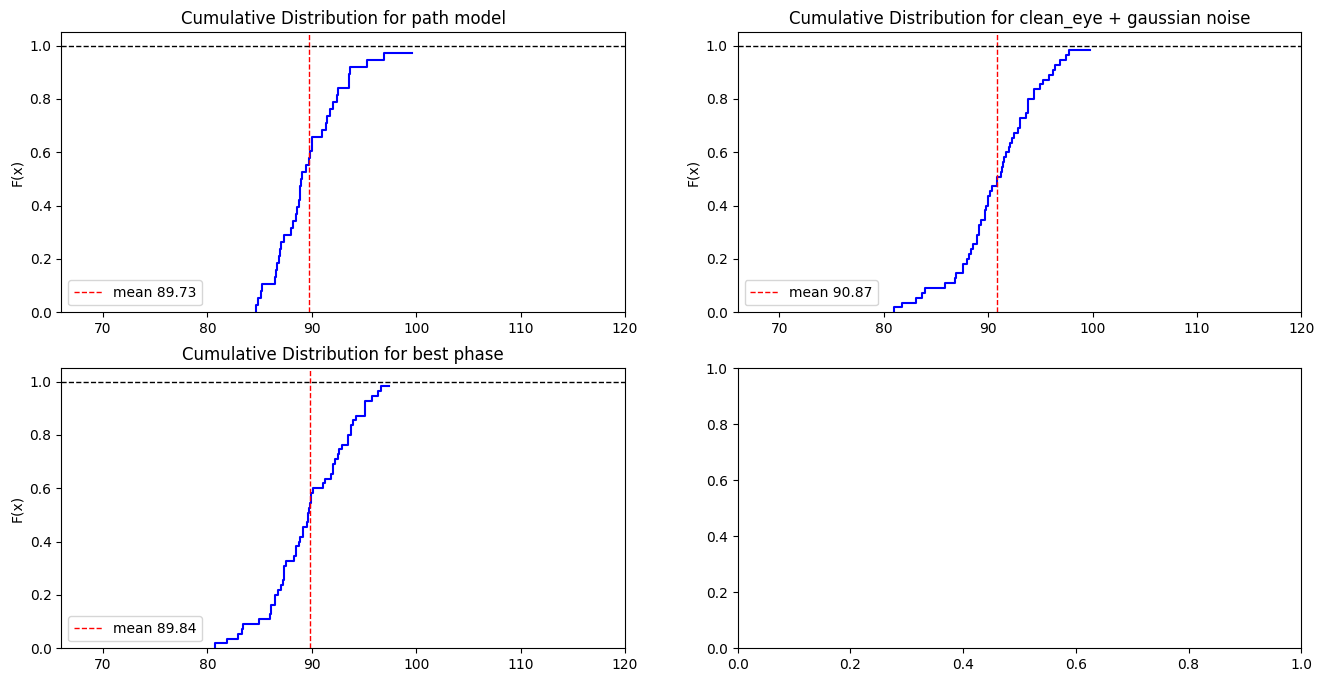

In [27]:
fig, axis = plt.subplots(2, 2, figsize=(16, 8))

for i in range(len(all_duration_error)):
    data = all_duration_error[i]
    # Quick ECDF alternative inside your loop:
    sorted_data = np.sort(data)
    y_values = np.arange(len(sorted_data)) / float(len(sorted_data))
    axis[i//2,i%2].step(sorted_data, y_values, color='blue')
    axis[i//2,i%2].set_title(f'Cumulative Distribution for {input_outputs[i]["model_name"]}')
    axis[i//2,i%2].set_xlim(66, 120)
    axis[i//2,i%2].set_ylim(0, 1.05) # CDF always ranges from 0 to 1
    
    axis[i//2,i%2].axvline(np.mean(data), color='red', linestyle='dashed', 
                    linewidth=1, label=f'mean {np.mean(data):.2f}')
    axis[i//2,i%2].axhline(1, color='black', linestyle='dashed', linewidth=1)
    axis[i//2,i%2].set_ylabel('F(x)')
    axis[i//2,i%2].legend()

plt.show()

In [28]:
ori_x = []
for path in all_model_x_list[0]:
    path_clone = path.copy()
    path_clone[0] = path_clone[0]*512
    path_clone[1] = path_clone[1]*320
    ori_x.append(path_clone)

In [29]:
gaze_list = [(ori_x,'sim_noise',1/16), 
             (all_model_y_list[0],'gt',1/16),   
             *[(all_model_reg_list[i],f'{input_outputs[i]['model_name']}', 1/16) for i in range(len(all_model_reg_list))]]

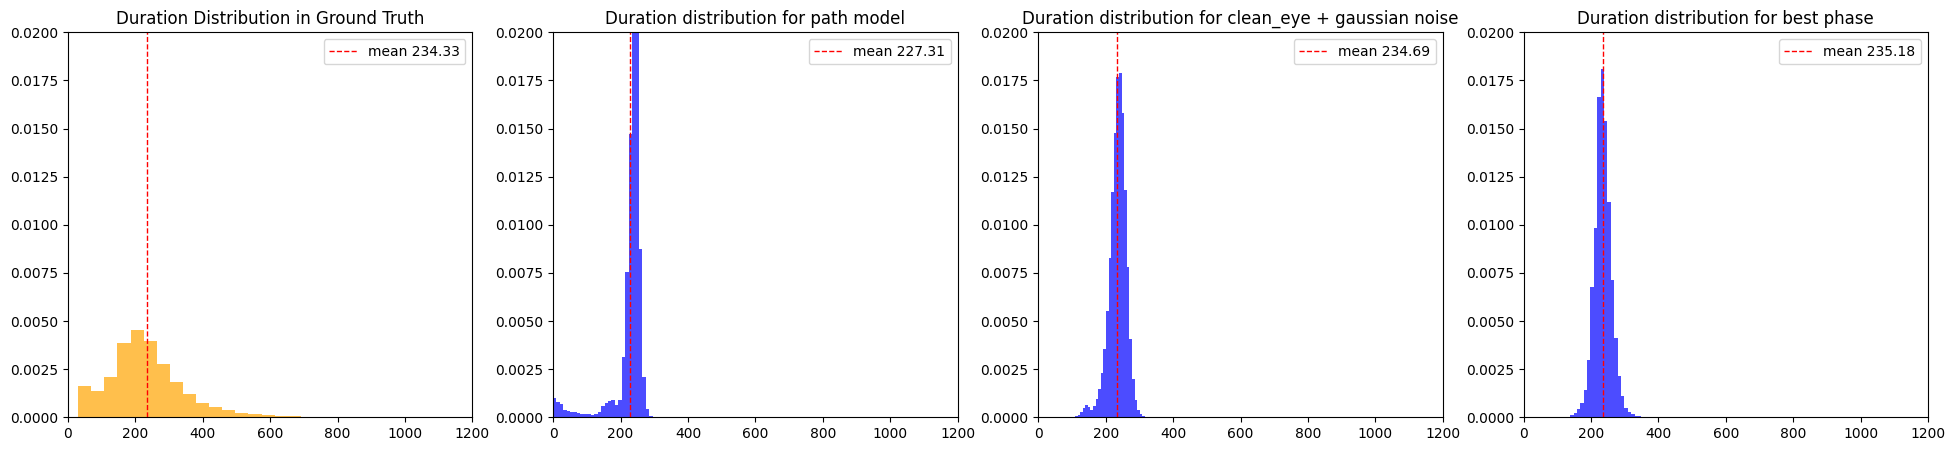

In [30]:
concatenated_y = np.concat([y[2] for y in all_model_y_list[0]])

# plot a hist of each array in two subplots
fig, axs = plt.subplots(1,1 + len(all_model_reg_list), figsize=(6*(1 + len(all_model_reg_list)),  5))
axs[0].hist(concatenated_y, bins=30, color='orange', alpha=0.7, density=True)
axs[0].set_title('Duration Distribution in Ground Truth')
axs[0].set_xlim(0, 1200)
axs[0].set_ylim(0, 0.02)
axs[0].axvline(np.mean(concatenated_y), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_y):.2f}')
axs[0].legend()
for i in range(len(all_model_reg_list)):
    concatenated_reg = np.concat([reg[2] for reg in all_model_reg_list[i]])
    concatenated_reg = concatenated_reg[concatenated_reg < 1200]
    axs[i+1].hist(concatenated_reg, bins=30, color='blue', alpha=0.7, density=True)
    axs[i+1].set_title(f'Duration distribution for {input_outputs[i]['model_name']}')
    axs[i+1].set_xlim(0, 1200)
    axs[i+1].set_ylim(0, 0.02)
    axs[i+1].axvline(np.mean(concatenated_reg), color='red', linestyle='dashed', linewidth=1, label = f'mean {np.mean(concatenated_reg):.2f}')
    axs[i+1].legend()
plt.show()

    


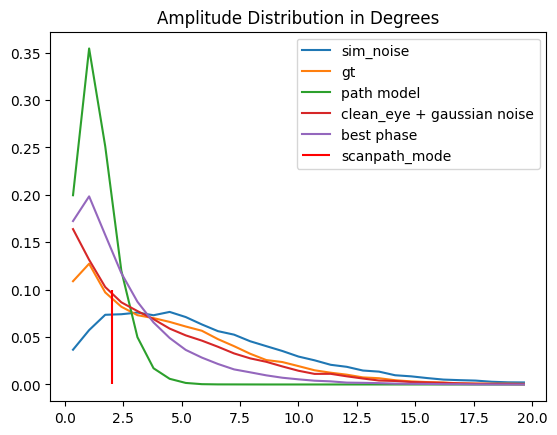

In [31]:
from src.eval.eval_utils import plot_amplitude_dist, plot_angle_distribution, plot_autocorrelation, plot_consecutive_angles, plot_vector_dist, calculate_relative_vectors                        
plot_amplitude_dist([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list],
                    [gaze[2] for gaze in gaze_list])

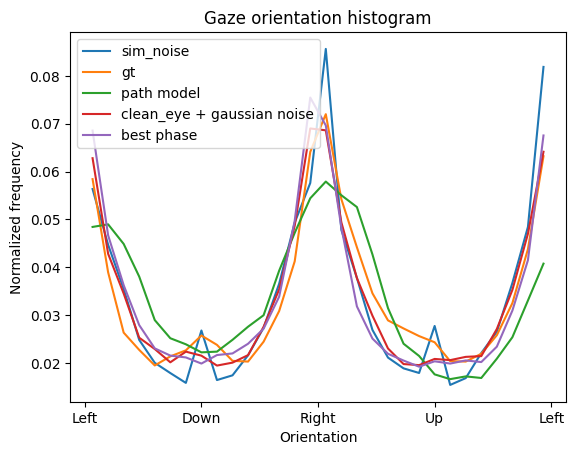

In [32]:
plot_angle_distribution([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

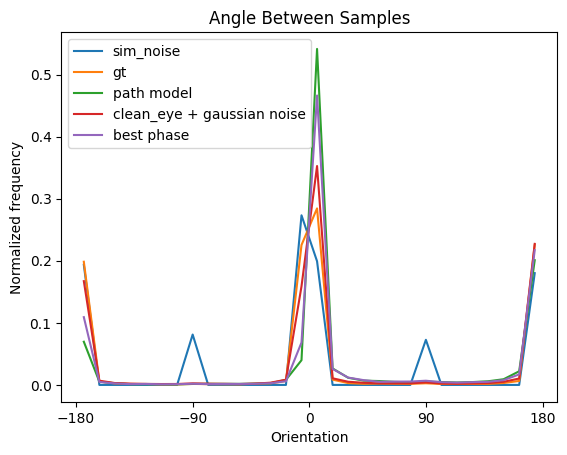

In [33]:
plot_consecutive_angles([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list])
plt.show()

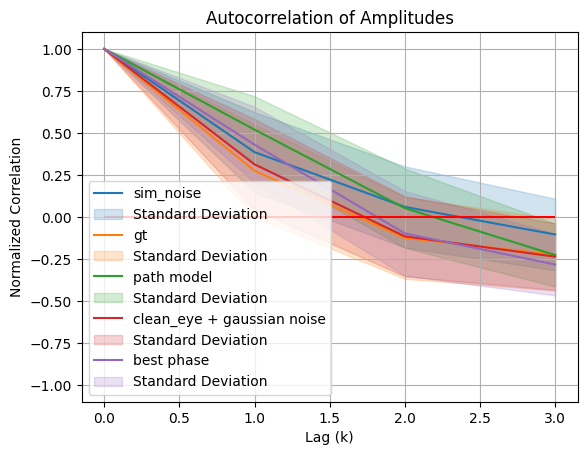

In [34]:
plot_autocorrelation([gaze[0] for gaze in gaze_list],
                    [gaze[1] for gaze in gaze_list], min_len=4)
plt.show()

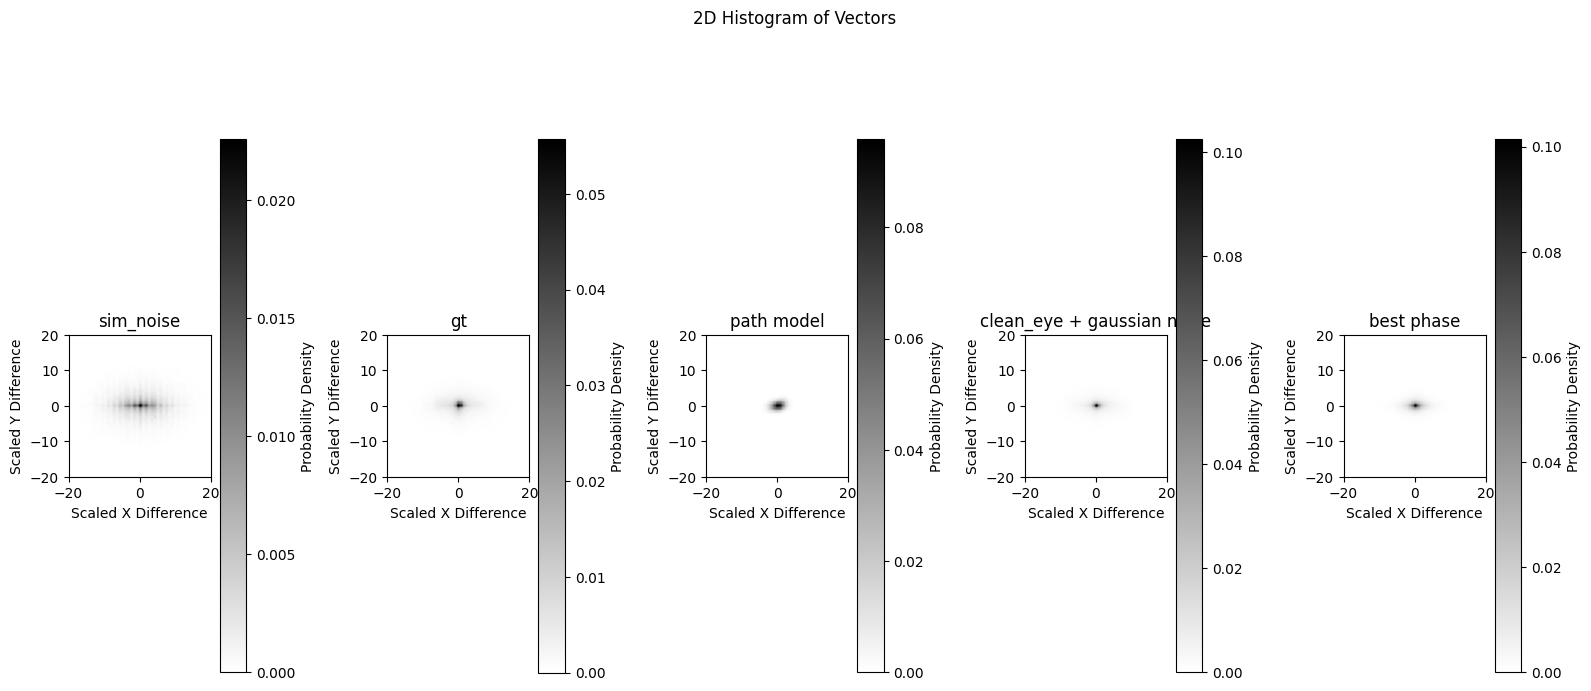

In [35]:
plot_vector_dist([[np.diff(gaze_sample[:2, :], axis=1) for gaze_sample in gaze[0]] for gaze in gaze_list],
                 [gaze[2] for gaze in gaze_list], 
                 [gaze[1] for gaze in gaze_list],)

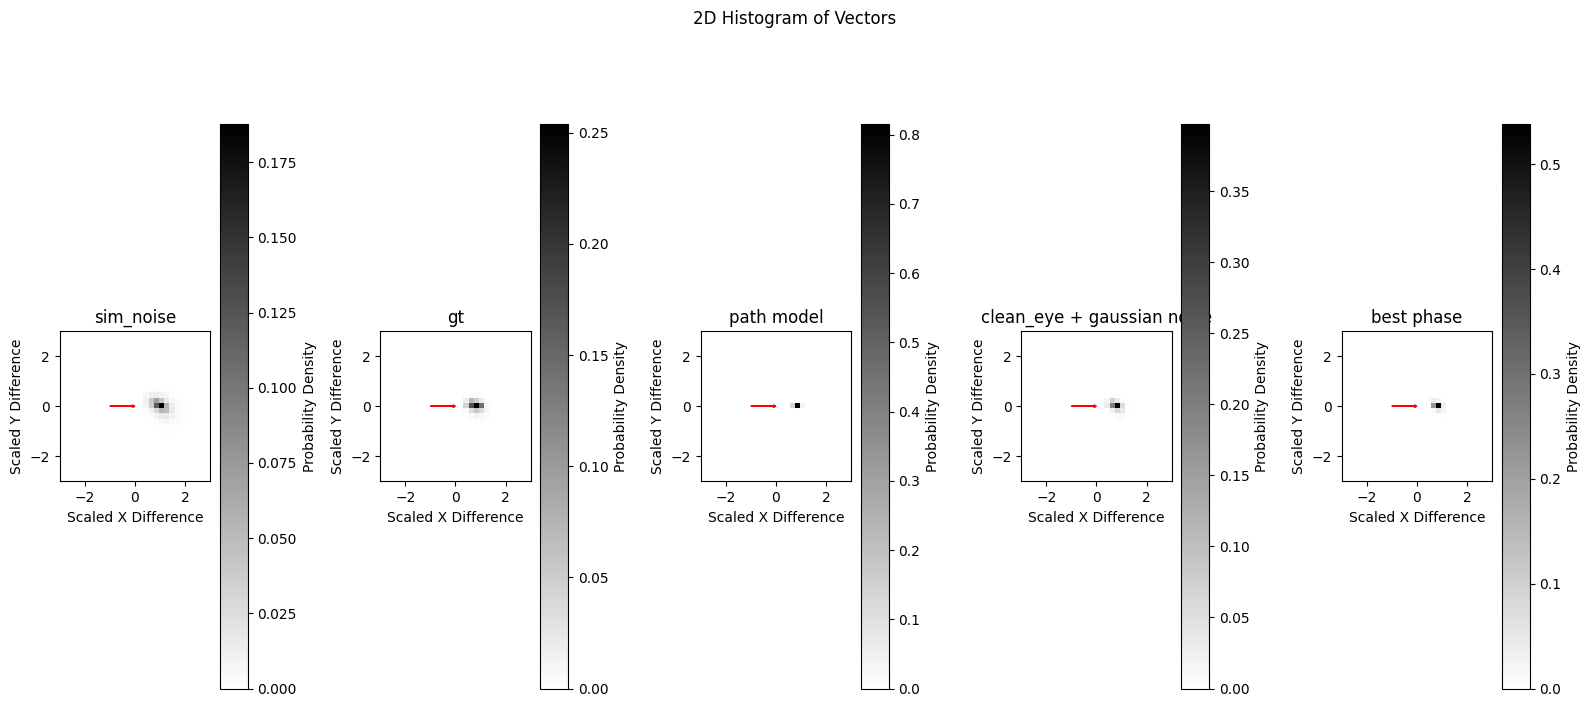

In [36]:
plot_vector_dist([[calculate_relative_vectors(gaze_sample) for gaze_sample in gaze[0]] for gaze in gaze_list],
                    [1 for _ in gaze_list],
                    [gaze[1] for gaze in gaze_list],-3,3,30, arrow= True)

plt.show()